In [34]:
#import statements
import pandas as pd
from bs4 import BeautifulSoup
import urllib3
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

Motivation for Performing The Analysis
=====================================
I'm looking to analyze the Android market determine what are the most popular types of apps,
looking at the different categories of apps and how they rank,
and what applications and types are users rating the highest
#### Main Data Source:
[Kaggle - Google Play Store Apps](#https://www.kaggle.com/lava18/google-play-store-apps)
Data has been included in this Github Repository for reference.
Data is read in and tidied in this section.
<strong>Data transformation operations</strong>

In [35]:
googlereviews = pd.read_csv('googleplaystore.csv')
googlesent = pd.read_csv('googleplaystore_user_reviews.csv')

#Tidying data, drop empty values
googlereviews.dropna(inplace=True)
googlesent.dropna(inplace=True)

#Tidying data, drop unneeded columns, convert columns to INT
googlereviews.drop(columns=['Android Ver', 'Current Ver', 'Size'])
googlereviews['Installs'] = googlereviews['Installs'].str.replace('+', '')
googlereviews['Installs'] = googlereviews['Installs'].str.replace(",","")
googlereviews['Installs'] = pd.to_numeric(googlereviews['Installs'])
googlereviews['Rating'] = pd.to_numeric(googlereviews['Rating'])
googlereviews['Reviews'] = pd.to_numeric(googlereviews['Reviews'])

Here is the data after it has been tidied up

In [36]:
googlesent.head()


,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [37]:
googlereviews.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


#### Web Scraping Data Source, second data source
The data was obtained from this website [App Annie](https://www.appannie.com/en/apps/google-play/top/)
Here the data is web scrapped, we find the elements that contain the table we are looking for.

In [38]:
http = urllib3.PoolManager()
response = http.request('GET',
                            'https://www.appannie.com/en/apps/google-play/top/')
soup = BeautifulSoup(response.data)
table = soup.find_all('div', attrs={'class': 'textContainer_ssmtv3'})

###### Cleaning the data
The data that is scrapped from the web, there are three tables on the web page. Table for paid, grossing and free.
The data is stripped down, and tidied up to only find the table with the applications names, ranking and type.
Additional tiding up and <strong>Aggregation</strong>

In [39]:
rank=1
ranked = []
track = 0
for rows in table:
    appname = rows.find('p', attrs={'class': 'n_1jv8115-o_O-Content_1xn1r0f-o_O-c0f2346_4s8r2l-o_O-text_7y41qf-o_O-item_9xo99e'}).get_text().strip()
    appname
    if track < 50:
        type = 'free'
    elif track < 100:
        type = 'paid'
    else:
        type = 'grossing'

    ranked.append([rank, appname, type])
    if rank ==50 or rank == 100:
        rank = 0
    rank += 1
    track += 1

rankeddf = pd.DataFrame(ranked, columns=["ranking", "name", "type"])
rankeddf.dropna(inplace=True)

Here is the data after tiding up

In [40]:
rankeddf.head()

,ranking,name,type
0,1,Crypto.com - Buy Bitcoin Now,free
1,2,GasBuddy: Find and Pay for Cheap Gas and Fuel,free
2,3,Catwalk Beauty,free
3,4,Coinbase – Buy & Sell Bitcoin. Crypto Wallet,free
4,5,Slice It All!,free


### Statistical Analysis and Graphics
Find the average rating of an application, grouping by category, and determining what are the top-rated categories.

In [41]:
avg_ratinghighest = googlereviews.groupby('Category')['Rating'].mean().sort_values(ascending=False)
avg_rating = googlereviews.groupby('Category')['Rating'].mean()
avg_ratinghighest.head()

Category
EVENTS                 4.435556
EDUCATION              4.389032
ART_AND_DESIGN         4.377049
BOOKS_AND_REFERENCE    4.346067
PERSONALIZATION        4.335256
Name: Rating, dtype: float64

The tope rated gategories are Events, education, Art & Design.
Graphics Showing the spread of the ratings:

<AxesSubplot:xlabel='Category', ylabel='Rating'>

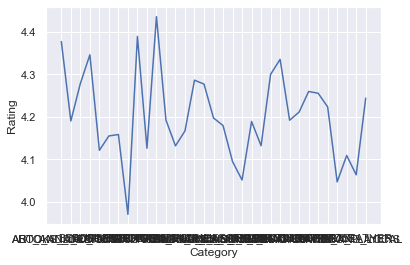

In [42]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=avg_rating)

Find the sentiment for the applications, grouping by the name and sentime, which can be negative, neutral or postivie.

In [51]:
googlesentcount = googlesent.groupby(['App', 'Sentiment']).count().reset_index()
googlesentcount.drop(columns=(['Sentiment_Polarity', 'Sentiment_Subjectivity']), inplace=True)
googlesentcount.rename(columns={'Translated_Review':'Count'}, inplace=True)
googlesentcount.head()

,App,Sentiment,Count
0,10 Best Foods for You,Negative,10
1,10 Best Foods for You,Neutral,22
2,10 Best Foods for You,Positive,162
3,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,Negative,1
4,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,Neutral,8
...,...,...,...
2371,Hotwire Hotel & Car Rental App,Neutral,11
2372,Hotwire Hotel & Car Rental App,Positive,16
2373,Housing-Real Estate & Property,Negative,10
2374,Housing-Real Estate & Property,Neutral,3


In [52]:
gspositive = googlesentcount[googlesentcount['Sentiment'] == 'Positive']
gspositive.sort_values()

,App,Sentiment,Count
2,10 Best Foods for You,Positive,162
5,104 找工作 - 找工作 找打工 找兼職 履歷健檢 履歷診療室,Positive,31
8,11st,Positive,23
11,1800 Contacts - Lens Store,Positive,64
14,1LINE – One Line with One Touch,Positive,27
...,...,...,...
2363,Hotels.com: Book Hotel Rooms & Find Vacation D...,Positive,39
2366,Hotspot Shield Free VPN Proxy & Wi-Fi Security,Positive,17
2369,Hotstar,Positive,14
2372,Hotwire Hotel & Car Rental App,Positive,16


##### Conclusion


##### One Feature that was not covered in Class
The feature that I used that was not covered in class was I created my Slide Desk directly from Juypter Notebook.